In [44]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt


## Task 1: Basics

In [12]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

In [3]:
!unzip "TestDataSet.zip"

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
  inflating: __MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/n02769748/
  inflating: __MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/n02834397/
  inflating: __MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/n02917067/
  inflating: __MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/n02808304/
  inflating: __MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/n03016953/
  inflating: __MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/n02793495/
  inflating: __MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/n02814533/
  inflating: __MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/n02837789/
  inflating: __MACOSX/TestDataSet/._n02837789  
   creating: TestDataSet/n02840245/
  inflating: __MACOSX/TestDataSet/._n02840245  
   creating: TestDataSet/n02992211/
  inflating: __MACOSX/TestDataSet/._n02992211  
   creating: TestDataSet

In [17]:
# preprocess images in TestDataSet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=5,)

In [14]:
import json

# Open and read the JSON file
with open('./TestDataSet/labels_list.json', 'r') as file:
    labels = json.load(file)

# Print the data
print(labels)

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

In [124]:
def get_accuracies(model, data_loader):
  correct_samples = 0
  top5_correct_samples = 0
  num_samples = 0
  accuracy = 0
  top5_acc = 0

  for step, (images, targets) in enumerate(data_loader):
    model.eval()
    outputs = model(images)
    correct_label = int(labels[step][:3])
    # calculate top1 accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_samples += preds.eq(correct_label).sum().item()
    # calulate top5 accuracy
    top5_preds = torch.topk(outputs, 5).indices
    top5_correct_samples += torch.isin(top5_preds, correct_label).sum().item()
    num_samples += images.size(0)

  accuracy = 100.0 * correct_samples / num_samples
  top5_acc = 100.0 * top5_correct_samples / num_samples
  print(f"top1 accuracy: {accuracy:.2f}%")
  print(f"top5 accuracy: {top5_acc:.2f}%")
  return accuracy, top5_acc

In [125]:
acc, top5acc = get_accuracies(pretrained_model, data_loader)

top1 accuracy: 75.80%
top5 accuracy: 94.40%


## Task 2: Pixel-Wise Attacks

In [43]:
# https://www.kaggle.com/code/haxothermic/fgsm-against-resnet-50-on-cifar-10
def fgsm_attack(model, criterion, images, labels, device, epsilon=0.02):
    images.requires_grad_(True)
    outputs = model(images)
    loss = criterion(outputs, labels).to(device)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    perturbations = epsilon * torch.sign(gradient)
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images, perturbations

In [112]:
def show_img(images, adversarial_images, adversarial_outputs):
  pred_num, top5_preds = torch.topk(adversarial_outputs, 5)
  for idx in range(len(images)):
    if 401 not in top5_preds[idx]:
      plt.figure()
      f, axis = plt.subplots(1,3, figsize=(8, 4))
      axis[0].imshow(images[idx].cpu().T.data.numpy())
      axis[0].set_title("Original")
      axis[1].imshow(adversarial_images[idx].cpu().T.data.numpy())
      axis[1].set_title("Adversarial")
      axis[2].bar(["".join(item) for item in top5_preds[idx].detach().numpy().astype(str)], pred_num[idx].detach().numpy())
      axis[2].set_title("Predictions")
      plt.show()

<Figure size 640x480 with 0 Axes>

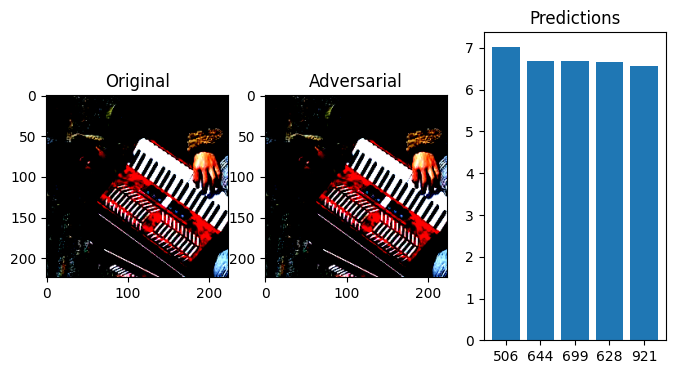

<Figure size 640x480 with 0 Axes>

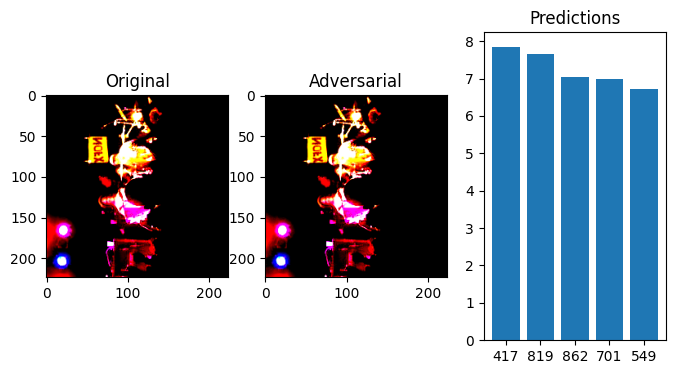

<Figure size 640x480 with 0 Axes>

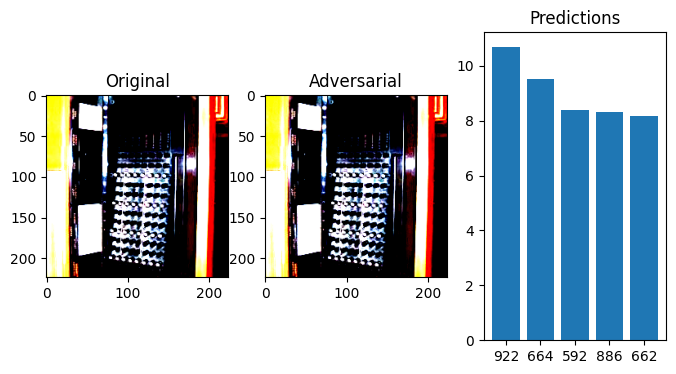

In [116]:
# create adversarial images and save as a dataset
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
AdversarialTestSet1 = torch.empty((0, 3, 224, 224))
for step, (images, targets) in enumerate(data_loader):
  adversarial_images, _ = fgsm_attack(pretrained_model, criterion, images, targets, device, epsilon)
  adversarial_outputs = pretrained_model(adversarial_images)
  AdversarialTestSet1 = torch.cat((AdversarialTestSet1, adversarial_images))

  if step == 0:
    show_img(images, adversarial_images, adversarial_outputs)

In [118]:
adv_data_loader = torch.utils.data.DataLoader(AdversarialTestSet1, batch_size=5,)

In [123]:
adv1_acc, adv1_top5acc = get_accuracies(pretrained_model, adv_data_loader)


top1 accuracy: 42.60%
top5 accuracy: 61.60%


In [ ]:
# todo: verify that the L∞ distance between new and original is no greater than ε = 0.02.

## Task 3: Improved Attacks

## Task 4: Patch Attacks

## Task 5: Transferring Attacks

In [ ]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')